In [24]:
#all packages and dataframes
import numpy as np
import classification
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ptitprince as pt
from matplotlib import colors as mcolors
%matplotlib inline
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
restDir=thisDir+'data/mvpa_data/rest/'
outDir = thisDir + 'output/mL/results/ridge/acc/'
subDir=thisDir+'output/subNetwork/'
randDir=thisDir+'output/randomIdx/'
Parcel_params = classification.loadParcelParams('Gordon333',thisDir+'data/Parcel_info/')
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
taskList=['mem','mixed','motor']
netList=['unassign','default', 'visual','fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon']
feature=[14808,10824,8736, 4620,5264,3151, 484, 4060, 2375,316, 564,45,21]
netRoi=dict([('unassign',14808),('default', 10824),('visual',8736),('fp', 4620),('dan',5264),('van',3151),('salience', 484),('co', 4060),('sm', 2375),('sm-lat', 316),('auditory', 564),('pmn',45),('pon',21)])
sns.set_style("white")
sns.set_context("talk")
# Gordan Palette
enmax_palette = Parcel_params['net_colors']
color_codes_wanted = Parcel_params['networks']
cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in enmax_palette]))
mcolors.get_named_colors_mapping().update(cdict)


#same task folds dataframes
DS_violin=pd.read_csv(outDir+'DS/folds/allFolds.csv')
DS_violin['Analysis']='Diff Sub'
CV=pd.read_csv(outDir+'CV/reformedFolds.csv')
CV.drop(columns='sub', inplace=True)
CV['Analysis']='Same Sub'
frames=[DS_violin, CV]
sameTask=pd.concat(frames)


#Visualizing change scores from within to between
t_CV=pd.read_csv(outDir+'CV/acc.csv')
t_DS=pd.read_csv(outDir+'DS/acc.csv', usecols=[1,2,3,4])
pairCV=pd.melt(t_CV,id_vars=['sub'],value_vars=['mixed','motor','mem'], var_name='task', value_name='acc')
pairDS=pd.DataFrame()
for task in taskList:
    tmp=t_DS[(t_DS['task']==task)]
    tmp_mu=tmp.groupby(['train_sub']).mean()
    tmp_mu['task']=task
    pairDS=pd.concat([pairDS,tmp_mu])
pairDS.reset_index(inplace=True)
pairDS.rename(columns={'train_sub':'sub'},inplace=True)
pairDS['Analysis']='Between'
pairCV['Analysis']='Within'
pair_res=pd.concat([pairDS, pairCV])
#motor
pair_motor=pair_res[pair_res.task=='motor']
#mixed
pair_mixed=pair_res[pair_res.task=='mixed']
#memory
pair_mem=pair_res[pair_res.task=='mem']

#change scores diff task same/diff sub
SS_diff=pd.read_csv(outDir+'SS/stats.csv', usecols=[1,2,3])
SS_diff['analysis']='Within'
BS_diff=pd.read_csv(outDir+'BS/stats.csv', usecols=[1,2,3])
BS_diff['analysis']='Between'
diff_res=pd.concat([SS_diff, BS_diff])
#motor
diff_motor=diff_res[diff_res.train_task=='motor']
#mixed
diff_mixed=diff_res[diff_res.train_task=='mixed']
#memory
diff_mem=diff_res[diff_res.train_task=='mem']

#plotACC of heatmaps for DS analysis
DS_heat=pd.read_csv(outDir+'DS/acc.csv', usecols=[1,2,3,4])

#different task analysis comparison does not require opening dataframe

#all statistics related tables will be computes in a separate script

#raincloud plot dataframes
#SS
SS=pd.read_csv(outDir+'SS/folds/allFolds.csv')
SS.drop(columns='test', inplace=True)
#reformate to get in long form
SS=SS.pivot_table(index = ['train',
                        SS.groupby(['train','sub']).cumcount()],
               columns = 'sub',
               values = 'acc')

SS.reset_index(inplace=True)
SS.drop(columns='level_1',inplace=True)


#subnetworks overlapped with random network sampling
SS_nets=pd.DataFrame()
DS_nets=pd.DataFrame()
CV_nets=pd.DataFrame()
BS_nets=pd.DataFrame()
for i in netList:
    tmpSS=pd.read_csv(subDir+i+'/results/ridge/acc/SS/acc.csv')
    #tmpSS['Analysis']='ridge'
    tmpSS['Network']=i
    tmpSS['Features']=netRoi[i]
    SS_nets=pd.concat([SS_nets,tmpSS])
    
    tmpDS=pd.read_csv(subDir+i+'/results/ridge/acc/DS/acc.csv')
    tmpDS['Network']=i
    tmpDS['Features']=netRoi[i]
    DS_nets=pd.concat([DS_nets,tmpDS])
    
    tmpBS=pd.read_csv(subDir+i+'/results/ridge/acc/BS/acc.csv')
    tmpBS['Network']=i
    tmpBS['Features']=netRoi[i]
    BS_nets=pd.concat([BS_nets,tmpBS])
    
    tmpCV=pd.read_csv(subDir+i+'/results/ridge/acc/CV/acc.csv')
    tmpCV=tmpCV.melt(id_vars='sub', value_vars=['mixed', 'motor','mem'], var_name='Task', value_name='Accuracy')
    tmpCV['Network']=i
    tmpCV['Features']=netRoi[i]
    CV_nets=pd.concat([CV_nets,tmpCV])
    
    
SS_nets.drop(columns='Unnamed: 0', inplace=True)
DS_nets.drop(columns='Unnamed: 0', inplace=True)
BS_nets.drop(columns='Unnamed: 0', inplace=True)
CV_nets.rename(columns={'Accuracy':'acc'},inplace=True)

rand_CV=pd.read_csv(randDir+'results/ridge/acc/CV/all.csv', usecols=[1,2,3])
rand_SS=pd.read_csv(randDir+'results/ridge/acc/SS/all.csv',usecols=[1,2,3,4,5])
rand_DS=pd.read_csv(randDir+'results/ridge/acc/DS/all.csv',usecols=[1,2,3,4,5])
rand_BS=pd.read_csv(randDir+'results/ridge/acc/BS/all.csv',usecols=[1,2,3,4,5,6])
#netRoi
#netRoi
SStotal=[]
DStotal=[]
CVtotal=[]
BStotal=[]
for i in netList:
    #CV
    CVtmp=CV_nets[(CV_nets['Network']==i)].acc.values
    CVacc=CVtmp.mean()
    CVtotal.append(CVacc)
    #SS
    SStmp=SS_nets[(SS_nets['Network']==i)].acc.values
    SSacc=SStmp.mean()
    SStotal.append(SSacc)
    #DS
    DStmp=DS_nets[(DS_nets['Network']==i)].acc.values
    DSacc=DStmp.mean()
    DStotal.append(DSacc)
    #BS
    BStmp=BS_nets[(BS_nets['Network']==i)].acc.values
    BSacc=BStmp.mean()
    BStotal.append(BSacc)

CV_mu=pd.DataFrame({'Network':netList, 'Acc':CVtotal,'Features':feature})
SS_mu=pd.DataFrame({'Network':netList, 'Acc':SStotal,'Features':feature})
DS_mu=pd.DataFrame({'Network':netList, 'Acc':DStotal,'Features':feature})
BS_mu=pd.DataFrame({'Network':netList, 'Acc':BStotal,'Features':feature})

#Resting state FC clustering
#Array of average rest FC per sub
restDF=np.empty((8,55278))
subCount=0
for sub in subList:
    fc=classification.matFiles(restDir+sub+'_parcel_corrmat.mat')
    #numpy average across 10 days
    subFC=np.average(fc, axis=0)
    restDF[subCount]=subFC
    subCount=subCount+1

In [ ]:
#distribution of accuracy between folds DS vs CV
sns.set_context('talk')
plt.figure(figsize=(15,8))
g=sns.violinplot(x='task', y='acc', hue='Analysis', data=sameTask, split=True)
g.set_xlabel('Task')
g.set(ylim=(0))
g.set_title('Distribution of Accuracy Across Folds')
plt.savefig(thisDir+'output/mL/images/ridge/figs/violin_plots.png', bbox_inches='tight')

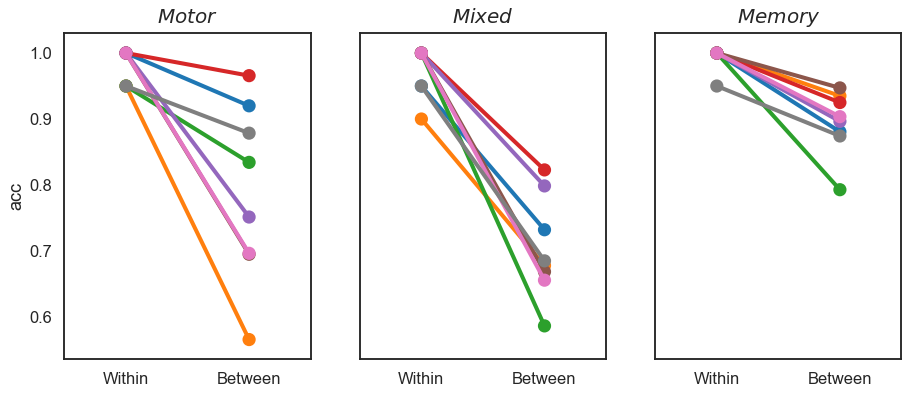

In [6]:
#Create figure space
fig=plt.figure(figsize=(15,6), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 3 columns
gs = gridspec.GridSpec(nrows=1, ncols=3)
#motor
ax1=fig.add_subplot(gs[0,0])
ax=sns.pointplot(x="Analysis",y="acc", hue="sub", ci=None, data=pair_motor, ax=ax1, order=['Within','Between'])
ax.legend_.remove()
ax.set_title('$Motor$', fontsize=20, pad=10)
plt.xlabel('')
#mixed
ax2=fig.add_subplot(gs[0,1],sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
ax=sns.pointplot(x="Analysis",y="acc", hue="sub", ci=None, data=pair_mixed, ax=ax2, order=['Within','Between'])
ax.legend_.remove()
ax.set_title('$Mixed$', fontsize=20, pad=10)
plt.ylabel('')
plt.xlabel('')
#memory
ax3=fig.add_subplot(gs[0,2],sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax=sns.pointplot(x="Analysis",y="acc", hue="sub", ci=None, data=pair_mem,ax=ax3, order=['Within','Between'])
ax.legend_.remove()
ax.set_title('$Memory$', fontsize=20, pad=10)
plt.ylabel('')
plt.xlabel('')

plt.savefig(thisDir+'output/mL/images/ridge/figs/point_plots.png', bbox_inches='tight')

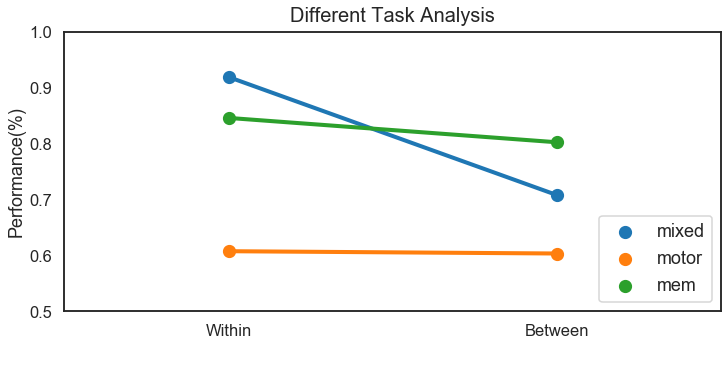

In [69]:
plt.figure(figsize=(10,5))
diff_plot=sns.pointplot(x="analysis",y="Mean", hue="train_task", ci=None, data=diff_res)
plt.legend(loc='lower right',fontsize='medium')
y=[.5,.6,.7,.8,.9,1.0]
plt.yticks(y)
plt.ylabel("Performance(%)")
diff_plot.set_title('Different Task Analysis', fontsize=20, pad=10)
diff_plot.set(xlabel=' ')
plt.savefig(thisDir+'output/mL/images/ridge/figs/taskpoint_plots.png', bbox_inches='tight')

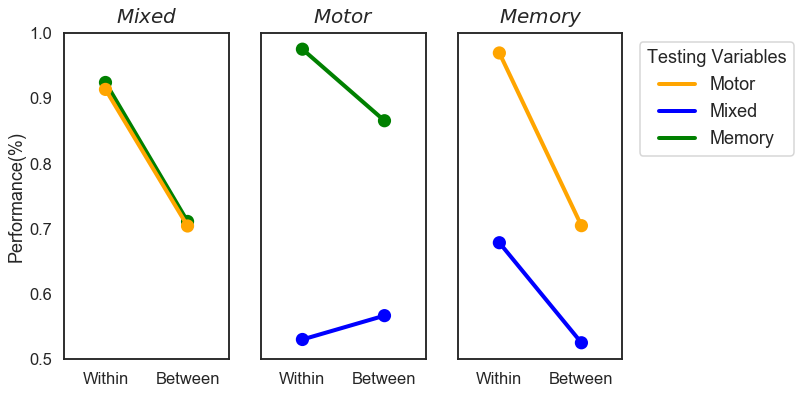

In [4]:
#separating out the different tasks 
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='green', lw=4)]
#Create figure space
fig=plt.figure(figsize=(10,6), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 3 columns
gs = gridspec.GridSpec(nrows=1, ncols=3)
#Mixed
ax1=fig.add_subplot(gs[0,0])
ax=sns.pointplot(x="analysis",y="Mean", hue="test_task",palette=['green','orange'], ci=None, data=diff_mixed, ax=ax1)
ax.legend_.remove()
y=[.5,.6,.7,.8,.9,1.0]
plt.yticks(y)
plt.ylabel("Performance(%)")
ax.set_title('$Mixed$', fontsize=20, pad=10)
ax.set(xlabel=' ')
#Motor
ax2=fig.add_subplot(gs[0,1])
plt.setp(ax2.get_yticklabels(), visible=False)
ax=sns.pointplot(x="analysis",y="Mean", hue="test_task", ci=None, palette=['green','blue'], data=diff_motor, ax=ax2)
ax.legend_.remove()
ax.set_title('$Motor$', fontsize=20, pad=10)
ax.set(xlabel=' ')
ax.set(ylabel=' ')
#Memory
ax3=fig.add_subplot(gs[0,2])
plt.setp(ax3.get_yticklabels(), visible=False)
ax=sns.pointplot(x="analysis",y="Mean", hue="test_task", ci=None, palette=['blue','orange'], data=diff_mem, ax=ax3)
ax.set_title('$Memory$', fontsize=20, pad=10)
ax.set(xlabel=' ')
ax.set(ylabel=' ')
ax.legend(custom_lines, ['Motor', 'Mixed', 'Memory'],loc='upper right',fontsize='medium',bbox_to_anchor=(2.1, 1),title='Testing Variables')
plt.savefig(thisDir+'output/mL/images/ridge/figs/sep_taskpoint_plots.png', bbox_inches='tight')

In [ ]:
#maybe edit this later to include all code so saved all in figs file
#figure of heatmaps across subjects
classification.plotACC(DS_heat, 'ridge', 'DS')
#heatmaps comparison of BS v SS
classification.heatmaps('ridge', 'SS')
classification.heatmaps('ridge', 'BS')

In [ ]:
#Create figure space
fig=plt.figure(figsize=(40,20), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 2 rows by 4 columns
gs = gridspec.GridSpec(nrows=2, ncols=4)
#gs = gridspec.GridSpec(nrows=4, ncols=2)
#MSC01
ax1=fig.add_subplot(gs[0,0])
dx='train'; dy='MSC01'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax1)
ax.tick_params(labelsize=30)
ax.set_title('$MSC01$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC02
ax2=fig.add_subplot(gs[0,1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
dx='train'; dy='MSC02'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax2)
ax.tick_params(labelsize=30)
ax.set_title('$MSC02$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC03
ax3=fig.add_subplot(gs[0,2], sharey=ax1)
#ax3=fig.add_subplot(gs[1,0], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
dx='train'; dy='MSC03'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax3)
ax.tick_params(labelsize=30)
ax.set_title('$MSC03$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC04
ax4=fig.add_subplot(gs[0,3], sharey=ax1)
#ax4=fig.add_subplot(gs[1,1], sharey=ax1)
plt.setp(ax4.get_yticklabels(), visible=False)
dx='train'; dy='MSC04'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax4)
ax.tick_params(labelsize=30)
ax.set_title('$MSC04$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)


#MSC05
ax5=fig.add_subplot(gs[1,0])
#ax5=fig.add_subplot(gs[2,0])
dx='train'; dy='MSC05'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax5)
ax.tick_params(labelsize=30)
ax.set_title('$MSC05$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC06
ax6=fig.add_subplot(gs[1,1], sharey=ax5)
#ax6=fig.add_subplot(gs[2,1], sharey=ax5)
plt.setp(ax6.get_yticklabels(), visible=False)
dx='train'; dy='MSC06'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax6)
ax.tick_params(labelsize=30)
ax.set_title('$MSC06$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC07
ax7=fig.add_subplot(gs[1,2], sharey=ax5)
#ax7=fig.add_subplot(gs[3,0], sharey=ax5)
plt.setp(ax7.get_yticklabels(), visible=False)
dx='train'; dy='MSC07'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax7)
ax.tick_params(labelsize=30)
ax.set_title('$MSC07$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC10
ax8=fig.add_subplot(gs[1,3], sharey=ax5)
#ax8=fig.add_subplot(gs[3,1], sharey=ax5)
plt.setp(ax8.get_yticklabels(), visible=False)
dx='train'; dy='MSC10'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax8)
ax.tick_params(labelsize=30)
ax.set_title('$MSC10$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

plt.savefig(thisDir+'output/mL/images/ridge/figs/raincloud_plots.png', bbox_inches='tight')

No handles with labels found to put in legend.


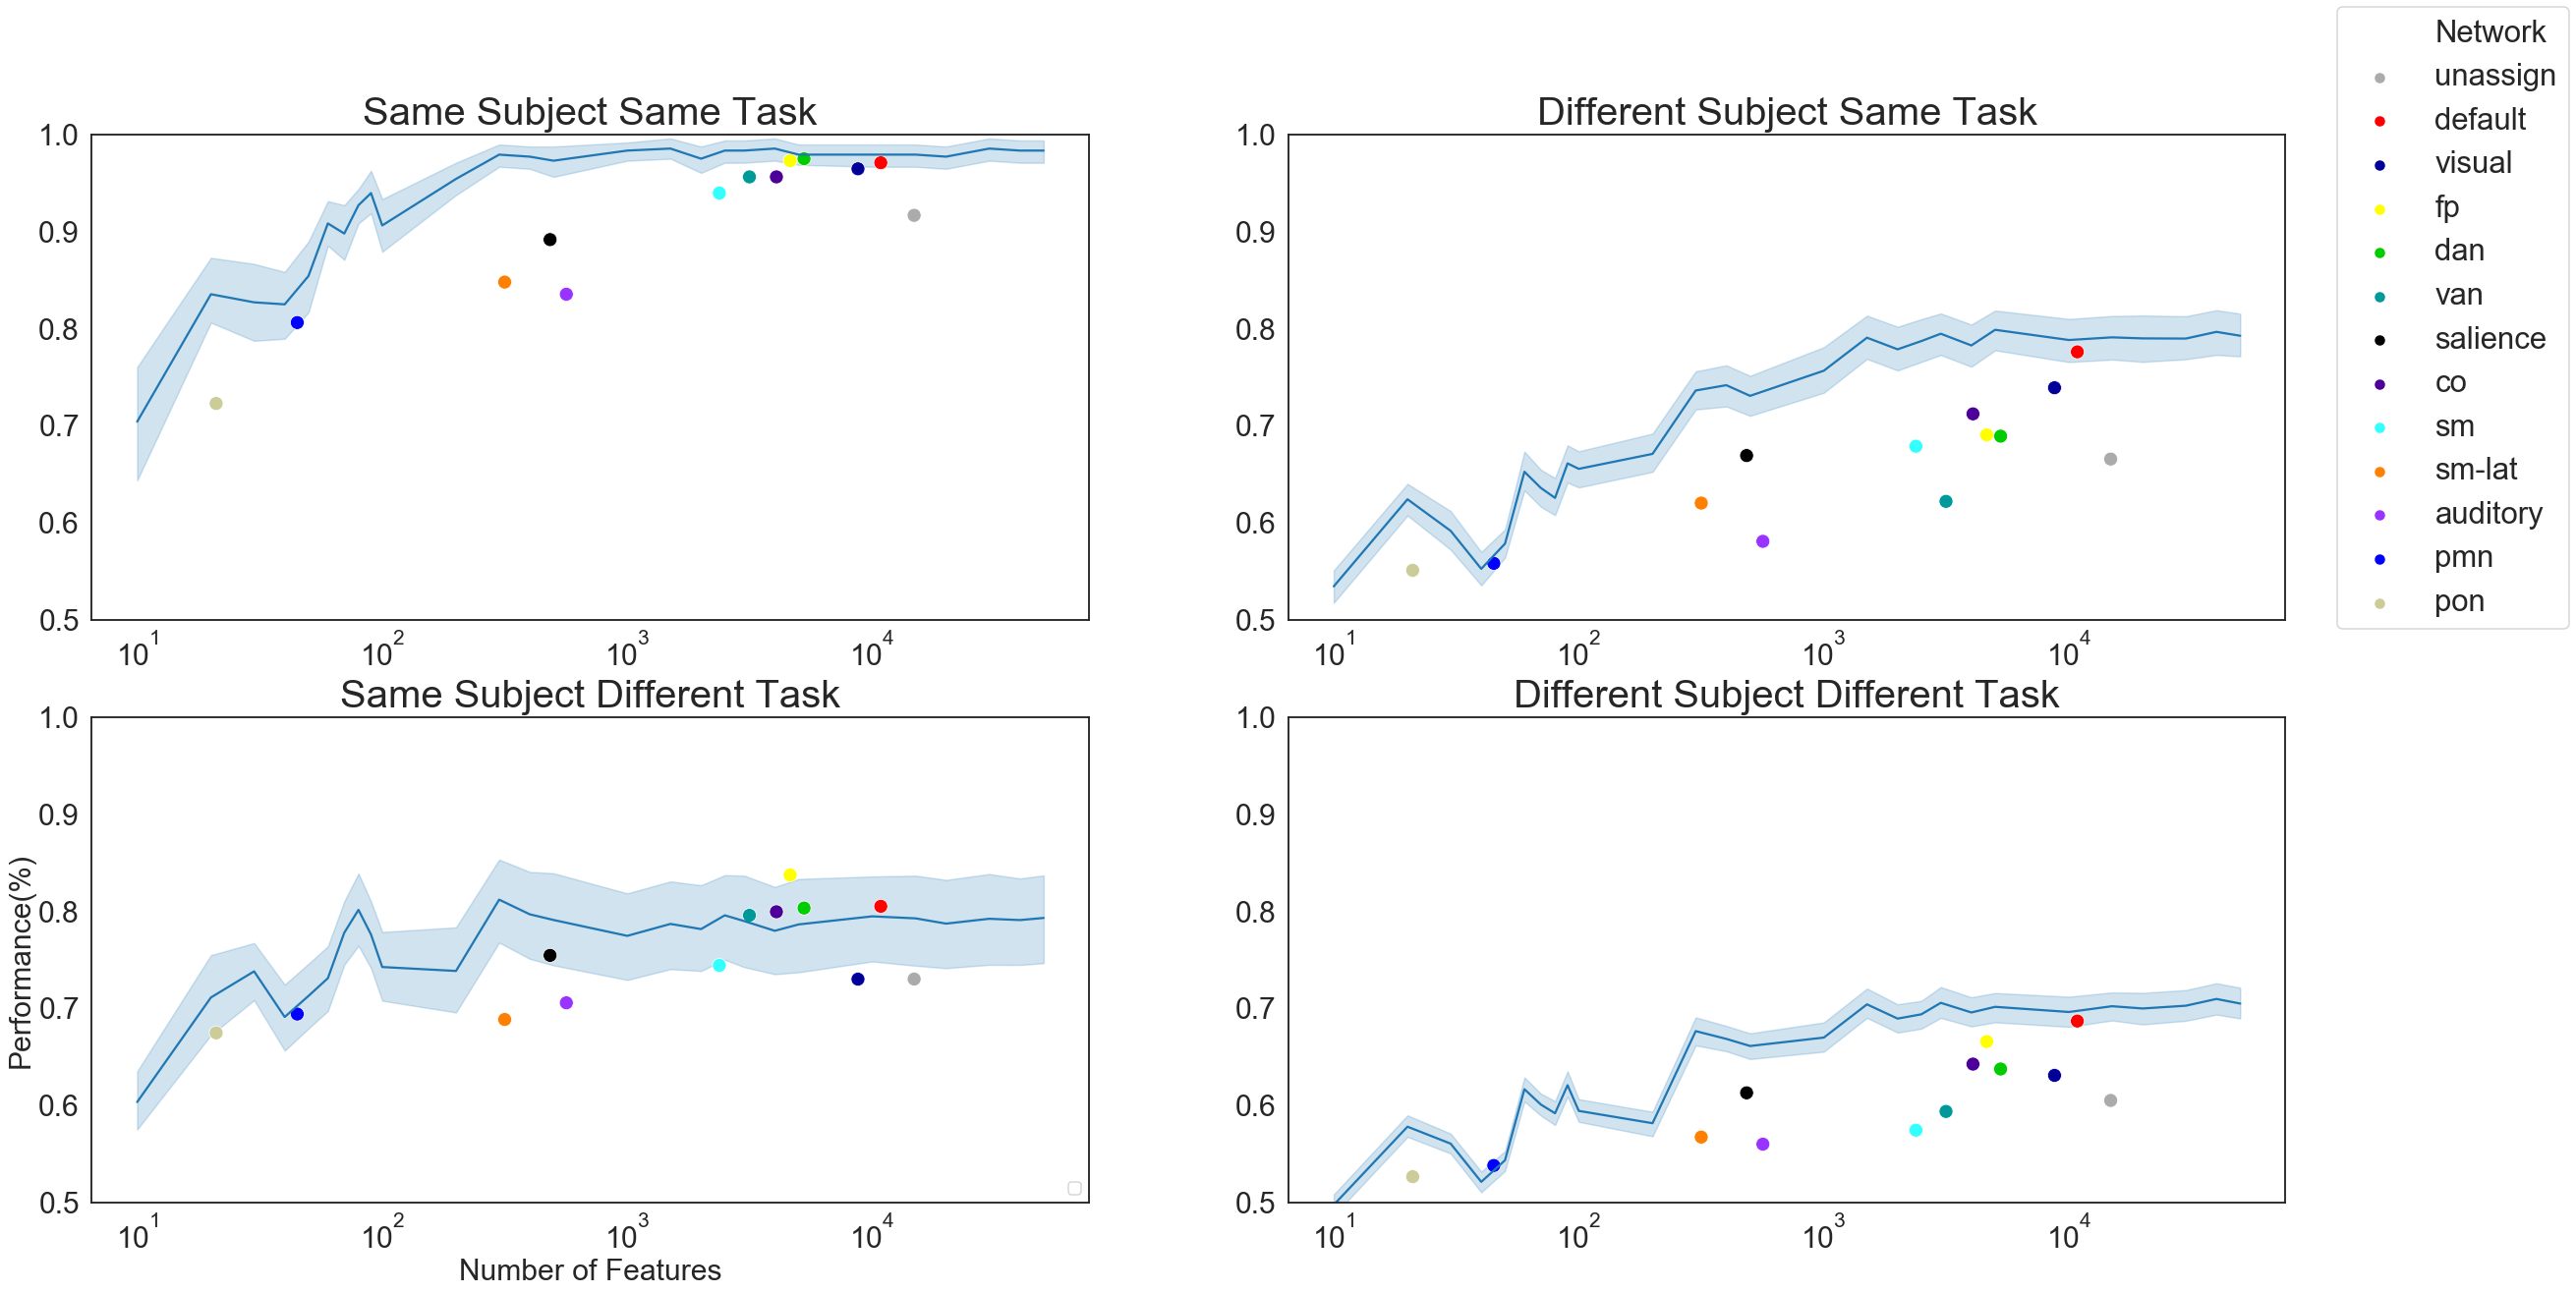

In [9]:
#lineplots overlapping subnetwork analysis
#Create figure space
fig=plt.figure(figsize=(40,20), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 2 rows by 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=2)

#CV
ax1=fig.add_subplot(gs[0,0])
ax = sns.lineplot(x="Features", y="Accuracy",data=rand_CV, ax=ax1)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=CV_mu, ax=ax1, color='r',s=200,legend=False,palette=["unassign","default", "visual",'fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon'])
#g.legend(loc='lower right')
ax.set_title('Same Subject Same Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)

#DS
ax2=fig.add_subplot(gs[0,1])
ax = sns.lineplot(x="Features", y="acc",data=rand_DS, ax=ax2)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=DS_mu, ax=ax2, color='r',s=200,palette=["unassign","default", "visual",'fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon'])
g.legend(loc='lower right')
ax.set_title('Different Subject Same Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)
plt.legend(bbox_to_anchor=(1.3, -0.05),loc='lower right',fontsize='xx-large')

#SS
ax3=fig.add_subplot(gs[1,0])
ax = sns.lineplot(x="Features", y="acc",data=rand_SS, ax=ax3)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=SS_mu, ax=ax3, color='r',s=200,legend=False,palette=["unassign","default", "visual",'fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon'])
g.legend(loc='lower right')
ax.set_title('Same Subject Different Task',fontsize=40, pad=10)
ax.set_ylabel("Performance(%)", fontsize=30)
ax.set_xlabel('Number of Features',fontsize=30)
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)

#BS
ax4=fig.add_subplot(gs[1,1])
ax = sns.lineplot(x="Features", y="acc",data=rand_BS, ax=ax4)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=BS_mu, ax=ax4, color='r',s=200,legend=False,palette=["unassign","default", "visual",'fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon'])
ax.set_title('Different Subject Different Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)
#fig.text(0.075, 0.5, "Performance(%)", rotation="vertical", va="center", fontsize="30")
#fig.text(0.45, 0.07, 'Number of Features', rotation="horizontal", va="center", fontsize="30")
plt.savefig(thisDir+'output/mL/images/ridge/figs/feature_plots.png', bbox_inches='tight')

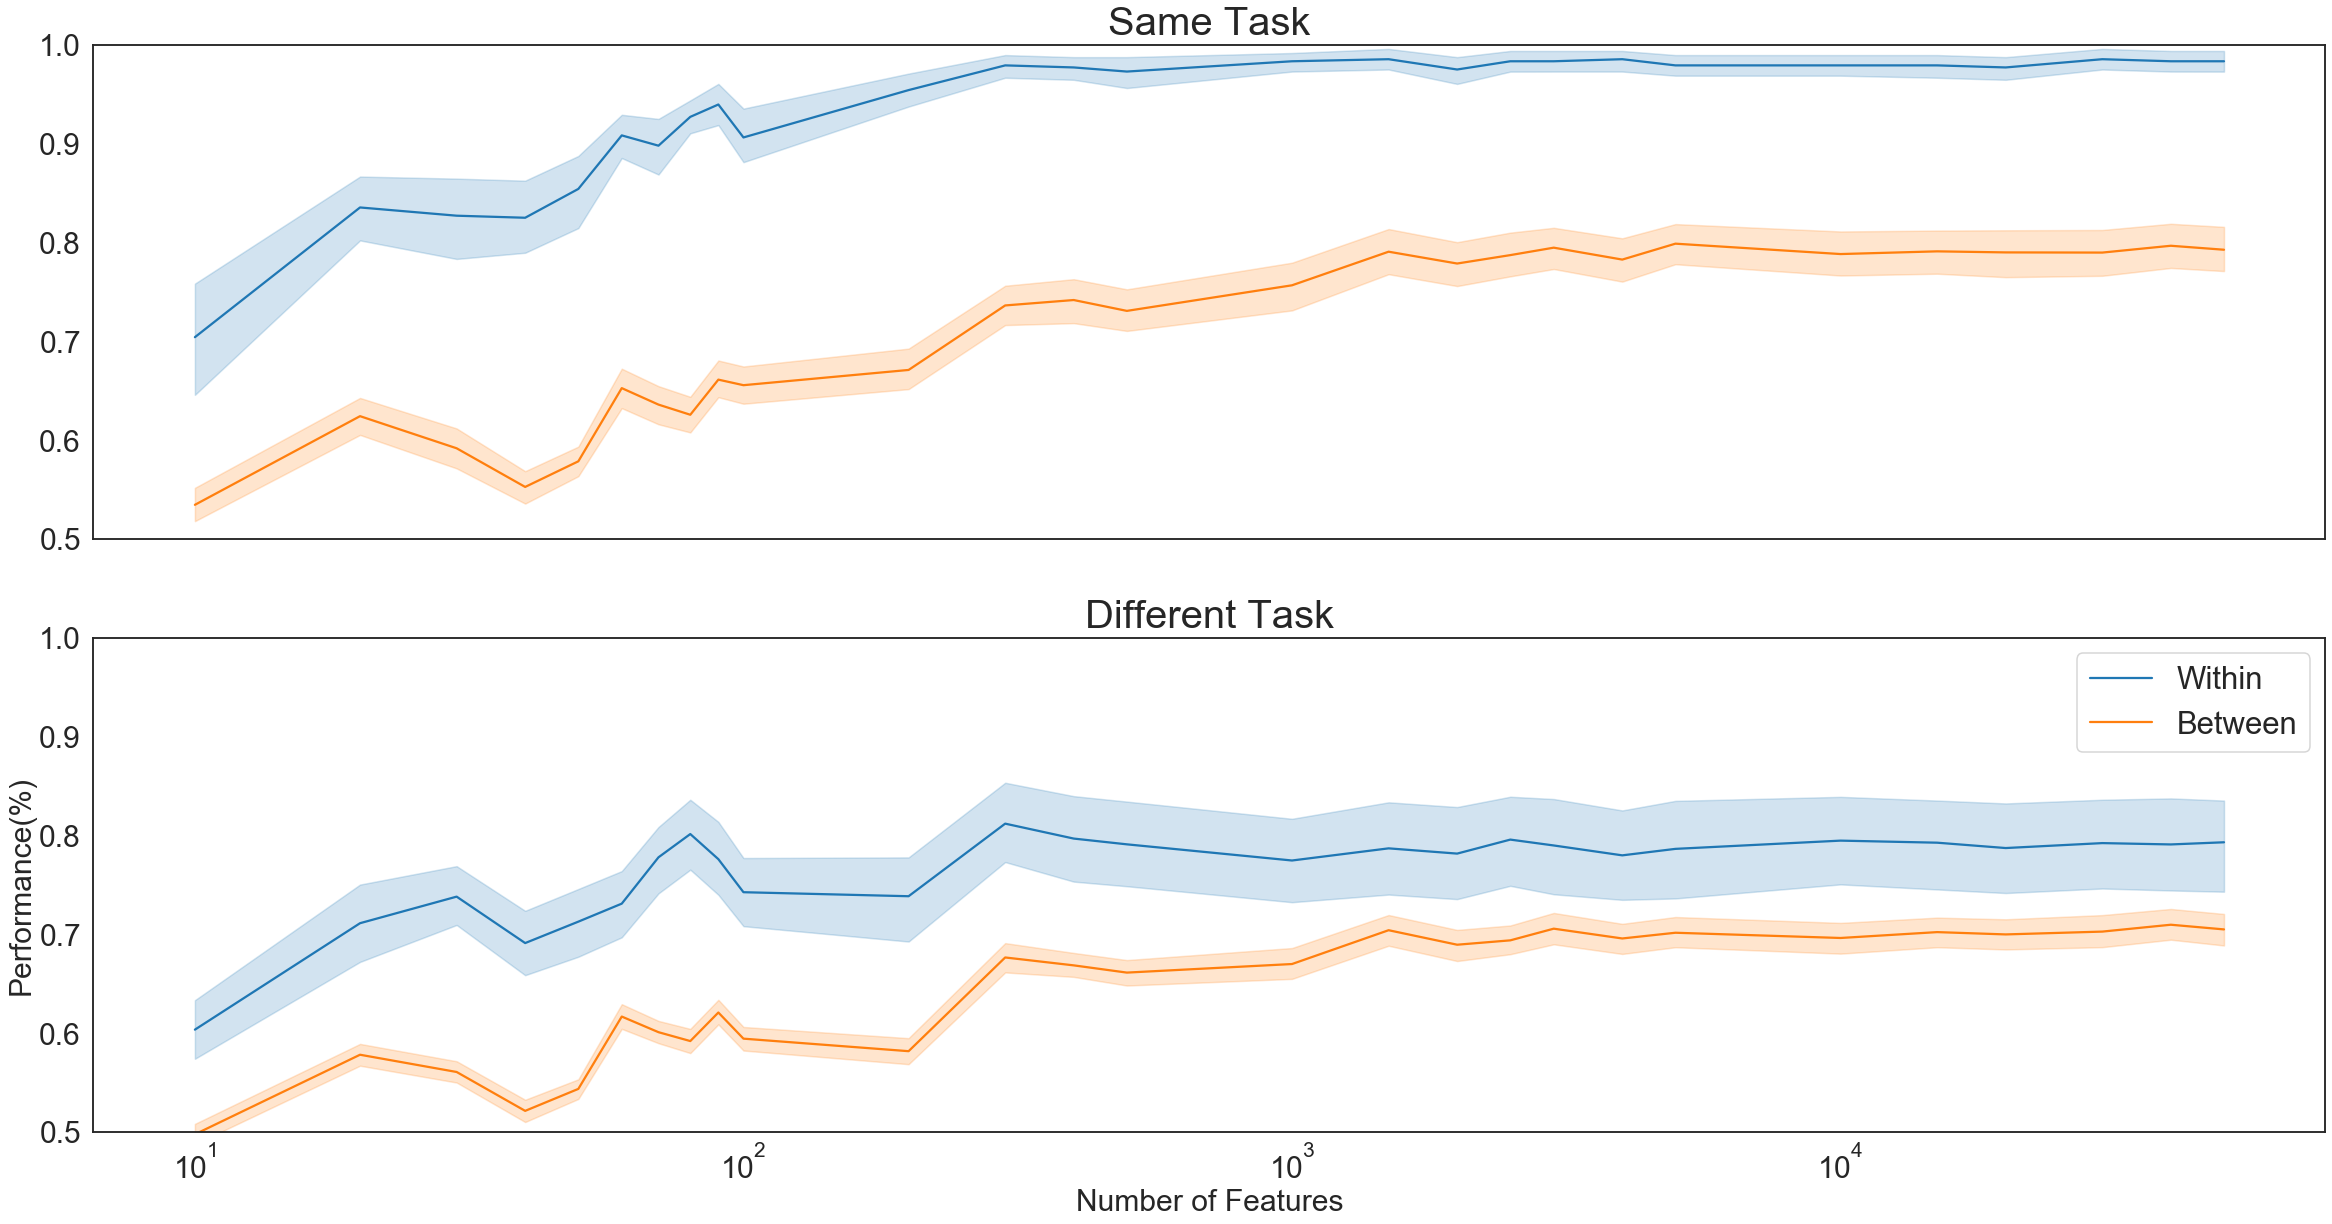

In [88]:
#lineplots random feature selection comparison of within and between 
#Create figure space
fig=plt.figure(figsize=(40,20), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 2 rows by 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=1)

#Same task comparison within and between 
ax1=fig.add_subplot(gs[0,0])
plt.setp(ax1.get_xticklabels(), visible=False)
ax = sns.lineplot(x="Features", y="Accuracy",data=rand_CV, ax=ax1)
ax.set(xscale="log")
g = sns.lineplot(x="Features", y="acc",data=rand_DS, ax=ax1)
ax.set_title('Same Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)

#Diff task comparison within and between
ax2=fig.add_subplot(gs[1,0])
ax = sns.lineplot(x="Features", y="acc",data=rand_SS, ax=ax2)
g = sns.lineplot(x="Features", y="acc",data=rand_BS, ax=ax2)
ax.set(xscale="log")
ax.set_title('Different Task',fontsize=40, pad=10)
ax.set_ylabel("Performance(%)", fontsize=30)
ax.set_xlabel('Number of Features',fontsize=30)
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)
ax.legend(('Within', 'Between'),loc='upper right',fontsize='xx-large')
plt.savefig(thisDir+'output/mL/images/ridge/figs/comb_feature_plots.png', bbox_inches='tight')

In [172]:
#8 subs, 3 tasks, 7 for each task/sub 
#dendrogram of all tasks for all subs
#ds=np.empty((24,7))
ds=np.empty((8,21))
taskList=['mem','motor','mixed']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
count=0
#for task in taskList:
    #tmp=DS_heat[(DS_heat['task']==task)]
for sub in subList:
    ds[count]=DS_heat[(DS_heat['train_sub']==sub)].acc.values
    count=count+1

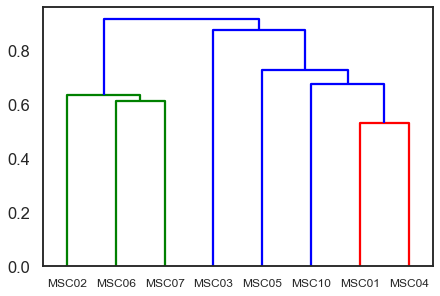

In [175]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
Y = pdist(ds, 'euclidean')
clustering=linkage(Y,'average')
dendrogram(clustering,labels=subList)
plt.savefig(thisDir+'output/mL/images/ridge/figs/allTasks_dendPlots.png', format='png')

In [166]:
#dendrogram for mixed only all subs
mixDS=np.empty((8,7))
tmp=DS_heat[(DS_heat['task']=='mixed')]
i=0
for sub in subList:
    mixDS[i]=tmp[(tmp['train_sub']==sub)].acc.values
    i=i+1

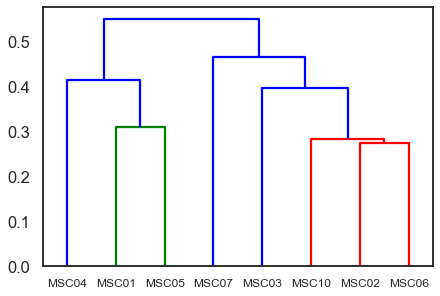

In [168]:
Y = pdist(mixDS, 'euclidean')
clustering=linkage(Y,'average')
dendrogram(clustering, labels=subList)
plt.savefig(thisDir+'output/mL/images/ridge/figs/mix_dendPlots.png', format='png')

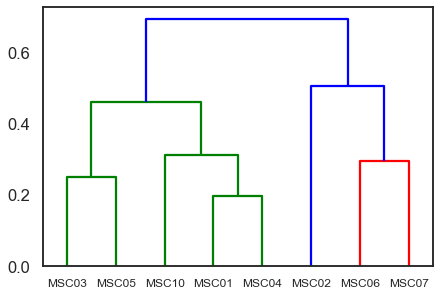

In [179]:
motDS=np.empty((8,7))
tmp=DS_heat[(DS_heat['task']=='motor')]
i=0
for sub in subList:
    motDS[i]=tmp[(tmp['train_sub']==sub)].acc.values
    i=i+1

Y = pdist(motDS, 'euclidean')
clustering=linkage(Y,'average')
dendrogram(clustering, labels=subList)
plt.savefig(thisDir+'output/mL/images/ridge/figs/motor_dendPlots.png', format='png')



In [181]:
memDS=np.empty((8,7))
tmp=DS_heat[(DS_heat['task']=='mem')]
i=0
for sub in subList:
    memDS[i]=tmp[(tmp['train_sub']==sub)].acc.values
    i=i+1

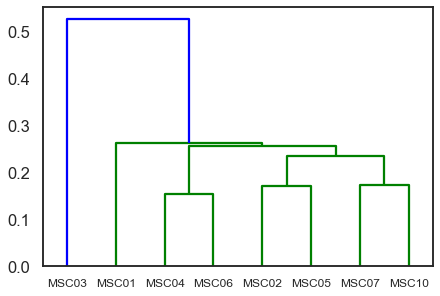

In [183]:
Y = pdist(memDS, 'euclidean')
clustering=linkage(Y,'average')
dendrogram(clustering, labels=subList)
plt.savefig(thisDir+'output/mL/images/ridge/figs/memory_dendPlots.png', format='png')

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [35.0, 35.0, 60.0, 60.0],
  [25.0, 25.0, 47.5, 47.5],
  [15.0, 15.0, 36.25, 36.25],
  [5.0, 5.0, 25.625, 25.625]],
 'dcoord': [[0.0, 40.93711014643988, 40.93711014643988, 0.0],
  [0.0, 41.49113501467305, 41.49113501467305, 0.0],
  [40.93711014643988, 42.37989903347867, 42.37989903347867, 41.49113501467305],
  [0.0, 43.42792448391066, 43.42792448391066, 42.37989903347867],
  [0.0, 44.15395611716393, 44.15395611716393, 43.42792448391066],
  [0.0, 44.878534366809674, 44.878534366809674, 44.15395611716393],
  [0.0, 45.26975214312169, 45.26975214312169, 44.878534366809674]],
 'ivl': ['MSC05',
  'MSC01',
  'MSC06',
  'MSC07',
  'MSC02',
  'MSC10',
  'MSC03',
  'MSC04'],
 'leaves': [4, 0, 5, 6, 1, 7, 2, 3],
 'color_list': ['b', 'b', 'b', 'b', 'b', 'b', 'b']}

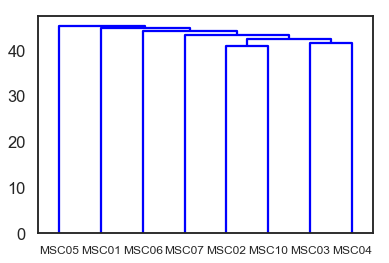

In [25]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
#make a dendrogram for clustering resting state FC
Y = pdist(restDF, 'euclidean')
clustering=linkage(Y,'average')
dendrogram(clustering, labels=subList)
#plt.savefig(thisDir+'output/mL/images/ridge/figs/rsFC_dendPlots.png', format='png')




In [23]:
Y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])